In [130]:
!rm -r book1
!rm *.tar.gz
!wget https://the-eye.eu/public/AI/pile_preliminary_components/books1.tar.gz
!tar -xf books1.tar.gz
path = 'books1/epubtxt/'
selected_book = 'crocodiles-spirit.epub.txt'

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

!pip3 install pytorch-nlp
from torchnlp.word_to_vector import GloVe
glove = GloVe(name='6B', dim='50')

from tqdm.notebook import tqdm
from collections import Counter, defaultdict
import numpy as np
import random
import time
import re

from torch import nn, tensor, optim
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

rm: cannot remove 'book1': No such file or directory
--2021-05-09 18:55:46--  https://the-eye.eu/public/AI/pile_preliminary_components/books1.tar.gz
Resolving the-eye.eu (the-eye.eu)... 162.213.130.242
Connecting to the-eye.eu (the-eye.eu)|162.213.130.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2404269430 (2.2G) [application/octet-stream]
Saving to: ‘books1.tar.gz’

books1.tar.gz       100%[===================>]   2.24G   110MB/s    in 21s     

2021-05-09 18:56:07 (108 MB/s) - ‘books1.tar.gz’ saved [2404269430/2404269430]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [131]:
def update_vocab(book, embd, vocab):
    text = re.sub(r"[^a-zA-Z0-9'!?;\.]", r" ", book)
    for sent in sent_tokenize(text):
        words = word_tokenize(sent)
        if len(words) > 100 or len(words) < 3:
            continue
        for word in words:
            word = word.lower()
            if word in embd:
                vocab.add(word)
            else:
                word = word.replace("'","")
                if word in embd:
                    vocab.add(word)

vocab = set(['<s>','</s>','<UKN>'])
with open(path+selected_book) as file:
    text = file.read()
    update_vocab(text, glove, vocab)

len(vocab)

9333

In [132]:
def sent_preprocess(sent, vocab):
    words = word_tokenize(sent)
    if len(words)>100 or len(words)<3:
        return None
    output = ['<s>']
    for word in words:
        word = word.lower()
        if word not in vocab:
            word = word.replace("'","")
        if word not in vocab:
            word = '<UKN>'
        output.append(word)
    output.append('</s>')
    return output

def preprocess(book, vocab, test_size=0.1):
    text = re.sub(r"[^a-zA-Z0-9'!?;\.]", r" ", book)
    data = list()
    sents = sent_tokenize(text)
    for i,sent in enumerate(tqdm(sents)):
        words = sent_preprocess(sent, vocab)
        if words is None:
            continue
        data.append(words)
    data = np.array(data)
    test_selection = np.zeros(data.shape[0], dtype=bool)
    test_selection[np.random.choice(data.shape[0], data.shape[0]//10, replace=False)] = True
    test = data[test_selection].tolist()
    train = data[~test_selection].tolist()
    return train,test

with open(path+selected_book) as file:
    text += file.read()+'\n'
train,test = preprocess(text, vocab)
len(train), len(test)

  0%|          | 0/21597 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(19414, 2157)

In [133]:
def indexing_words(vocabs):
    
    word_to_index = dict()
    index_to_word = dict()
    for i, word in tqdm(enumerate(vocabs)):
        
        word_to_index[word] = i+1
        index_to_word[i+1] = word
        
    word_to_index['<pad>'] = 0
    index_to_word[0] = '<pad>'
    
    return word_to_index, index_to_word

word_to_index, index_to_word = indexing_words(vocab)
vocab.add('<pad>')

0it [00:00, ?it/s]

In [134]:
def replace_words_by_index(data, word_to_index):
    
    new_data = []
    for row in tqdm(data):
        indexed_row = [word_to_index[word] for word in row]
        new_data.append(indexed_row)
        
    return new_data

train = replace_words_by_index(train, word_to_index)
test = replace_words_by_index(test, word_to_index)
len(test), len(train)

  0%|          | 0/19414 [00:00<?, ?it/s]

  0%|          | 0/2157 [00:00<?, ?it/s]

(2157, 19414)

In [135]:
' '.join([index_to_word[idx] for idx in test[326]])

"<s> and it was n't like rodgers was an uncommon name . </s>"

In [136]:
' '.join([index_to_word[idx] for idx in test[892]])

'<s> its best feature was it was inexpensive but close to things so she could get rid of her car if needed . </s>'

In [137]:
' '.join([index_to_word[idx] for idx in test[920]])

'<s> she is enchanting and i want to know who she is . </s>'

In [138]:
def generate_x_y(data):
    
    x = [tensor(word_list[:-1]) for word_list in data]
    y = [tensor(word_list[1:]) for word_list in data]
    seq_len = [len(word_list)-1 for word_list in data]
            
    return x, y, seq_len

x_train, y_train, seq_len_train = generate_x_y(train)
x_test, y_test, seq_len_test = generate_x_y(test)

In [139]:
test_x_lengths = np.array([len(row) for row in x_test])
train_x_lengths = np.array([len(row) for row in x_train])

test_y_lengths = np.array([len(row) for row in y_test])
train_y_lengths = np.array([len(row) for row in y_train])

x_train = pad_sequence(x_train, batch_first=True, padding_value=word_to_index['<pad>'])
y_train = pad_sequence(y_train, batch_first=True, padding_value=word_to_index['<pad>'])

print(x_train.shape, y_train.shape)

x_test = pad_sequence(x_test, batch_first=True)
y_test = pad_sequence(y_test, batch_first=True)

print(x_test.shape, y_test.shape)

torch.Size([19414, 101]) torch.Size([19414, 101])
torch.Size([2157, 79]) torch.Size([2157, 79])


In [140]:
import numpy as np
def generate_batches(x, y, lengths, batch_size):
    
    indices = [i for i in range(len(x))]
    np.random.shuffle(indices)
    
    try:
        start = 0
        while start < len(x):
            batch_indices = indices[start:start+batch_size]
            yield x[batch_indices], y[batch_indices], lengths[batch_indices]
            start += batch_size
    except:
        batch_indices = indices[start:]
        return x[batch_indices], y[batch_indices], lengths[batch_indices]

In [141]:
class LanguageModel(nn.Module):
    
    def __init__(self, hidden_dim, embedding_dim, n_lsmt_layers, input_dim, output_dim):
        
        super(LanguageModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.n_layers = n_lsmt_layers
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=word_to_index['<pad>'])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_lsmt_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, sequence, hidden, seq_lens=None, eval_=False):
        
        if eval_ == False:
            max_length = len(sequence[0])
            embedded = self.embedding(sequence)
            embedded = pack_padded_sequence(embedded, seq_lens, batch_first=True, enforce_sorted=False)
            lstm_out, hidden = self.lstm(embedded, hidden)
            lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True, total_length=max_length)
            lstm_out = lstm_out.reshape(-1, self.hidden_dim)
            output = self.linear(lstm_out)
        else:
            embedded = self.embedding(sequence)
            lstm_out, hidden = self.lstm(embedded, hidden)
            lstm_out = lstm_out.reshape(-1, self.hidden_dim)
            output = self.linear(lstm_out)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                    weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        
        return hidden

In [142]:
def train(model, vocab, epochs=100):
        
    losses, test_losses = [], []
    batch_loss = None

    loss=nn.CrossEntropyLoss()
    opt=optim.Adam(model.parameters(), lr=0.001)

    model.train()

    for epoch in range(epochs):
        
        print(f'============================== epoch {epoch}, loss {batch_loss}')
        start = time.time()
        
        for x_batch, y_batch, seq_lens in generate_batches(x_train, y_train, train_x_lengths, 256):

            hidden = model.init_hidden(len(x_batch))
            hidden = tuple([h.data for h in hidden])
            
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()

            model.zero_grad()

            y_pred, hidden = model(x_batch, hidden, seq_lens=seq_lens)
            batch_loss = loss(y_pred, y_batch.view(-1))
            batch_loss.backward()
            opt.step()

            losses.append(batch_loss)
            
            with torch.no_grad():

                test_loss = 0
                for x_batch, y_batch, seq_lens in generate_batches(x_test, y_test, test_x_lengths, 256):

                    hidden = model.init_hidden(len(x_test))
                    hidden = tuple([h.data for h in hidden])
                    x_batch = x_batch.cuda()
                    y_batch = y_batch.cuda()

                    y_pred, hidden = model(x_batch, hidden, seq_lens=seq_lens)
                    test_loss += loss(y_pred, y_batch.view(-1))
                test_losses.append(test_loss)

        print(f'passed time: {time.time() - start}')
        
    return losses, test_losses

In [185]:
def predict(model, word, hidden, k=3):
    
    x = np.array([[word_to_index[word]]])
    x = torch.from_numpy(x).cuda()
    
    predicted, hidden = model(x, hidden, eval_=True)
    probs = F.softmax(predicted, dim=1).data
    probs = probs.cpu().numpy()
    probs = probs.reshape(probs.shape[1],)
    
    indices = probs.argsort()[-k:][::-1]
    indices = [idx for idx in indices if index_to_word[idx] != '<UKN>' and index_to_word[idx] != '<pad>']
    selected = indices[0]
    
    return index_to_word[selected], hidden


def text_generation(model, init_words, size=50):
    
    model.eval()
    
    hidden = model.init_hidden(1)
    
    word_list = init_words.split()
    for word in word_list:
        predicted, hidden = predict(model, word, hidden)
        
    word_list.append(predicted)
    for i in range(size-1):
        predicted, hidden = predict(model, word_list[-1], hidden)
        word_list.append(predicted)
        
    return word_list

In [ ]:
lstm = LanguageModel(100, 50, 3, len(vocab), len(vocab))
lstm.cuda()

losses, test_losses = train(lstm, vocab)

In [ ]:
plt.plot([x for x in range(len(losses))], losses)
plt.plot([x for x in range(len(test_losses))], test_losses)

In [145]:
import pickle
with open('../input/pickled/1-train_losses.pkl', 'rb') as file:
    losses = pickle.load(file)
with open('../input/pickled/1-test_losses.pkl', 'rb') as file:
    test_losses = pickle.load(file)
with open('../input/pickled/1-100-50-3-model.pkl', 'rb') as file:
    lstm = pickle.load(file)

In [ ]:
lstm2 = LanguageModel(100, 50, 4, len(vocab), len(vocab))
lstm2.cuda()

losses2, test_losses2 = train(lstm2, vocab)

In [146]:
import pickle
with open('../input/pickled/2-train_losses.pkl', 'rb') as file:
    losses2 = pickle.load(file)
with open('../input/pickled/2-test_losses.pkl', 'rb') as file:
    test_losses2 = pickle.load(file)
with open('../input/pickled/2-100-50-4-model.pkl', 'rb') as file:
    lstm2 = pickle.load(file)

In [ ]:
plt.plot([x for x in range(len(losses2))], losses2)
plt.plot([x for x in range(len(test_losses2))], test_losses2)

In [167]:
lstm3 = LanguageModel(200, 50, 3, len(vocab), len(vocab))
lstm3.cuda()

losses3, test_losses3 = train(lstm3, vocab)

============================== epoch 0, loss None
passed time: 25.915771961212158
============================== epoch 1, loss 8.42918586730957
passed time: 25.938252687454224
============================== epoch 2, loss 8.302865028381348
passed time: 25.968496561050415
============================== epoch 3, loss 8.185139656066895
passed time: 25.87722110748291
============================== epoch 4, loss 8.070135116577148
passed time: 26.024088382720947
============================== epoch 5, loss 7.948713302612305
passed time: 26.01451849937439
============================== epoch 6, loss 7.804805278778076
passed time: 25.95759606361389
============================== epoch 7, loss 7.672194004058838
passed time: 25.872529983520508
============================== epoch 8, loss 7.560832977294922
passed time: 25.98880648612976
============================== epoch 9, loss 7.427978515625
passed time: 25.90628170967102
============================== epoch 10, loss 7.326265811920166
passed t

In [ ]:
import pickle
with open('3-train_losses.pkl', 'wb') as file:
    pickle.dump(losses3, file)
with open('3-test_losses.pkl', 'wb') as file:
    pickle.dump(test_losses3, file)
with open('3-200-50-3-model.pkl', 'wb') as file:
    pickle.dump(lstm3, file)

In [ ]:
plt.plot([x for x in range(len(losses3))], losses3)
plt.plot([x for x in range(len(test_losses3))], test_losses3)

In [ ]:
lstm4 = LanguageModel(100, 100, 3, len(vocab), len(vocab))
lstm4.cuda()

losses4, test_losses4 = train(lstm4, vocab)

In [148]:
import pickle
with open('../input/pickled/4-train_losses.pkl', 'rb') as file:
    losses4 = pickle.load(file)
with open('../input/pickled/4-test_losses.pkl', 'rb') as file:
    test_losses4 = pickle.load(file)
with open('../input/pickled/4-100-100-3-model.pkl', 'rb') as file:
    lstm4 = pickle.load(file)

In [ ]:
plt.plot([x for x in range(len(losses4))], losses4)
plt.plot([x for x in range(len(test_losses4))], test_losses4)

In [ ]:
lstm5 = LanguageModel(100, 50, 3, len(vocab), len(vocab))
lstm5.cuda()

losses5, test_losses5 = train(lstm5, vocab)

In [149]:
import pickle
with open('../input/pickled/5-train_losses.pkl', 'rb') as file:
    losses5 = pickle.load(file)
with open('../input/pickled/5-test_losses.pkl', 'rb') as file:
    test_losses5 = pickle.load(file)
with open('../input/pickled/5-100-50-3(lr)-model.pkl', 'rb') as file:
    lstm5 = pickle.load(file)

In [ ]:
plt.plot([x for x in range(len(losses5))], losses5)
plt.plot([x for x in range(len(test_losses5))], test_losses5)

In [150]:
def plot_differences(data1, data2, labels, x_label, y_label):
    
    x = [i for i in range(len(data1))]
    plt.plot(x, data1, label=labels[0])
    plt.plot(x, data2, label=labels[1])
    plt.legend(loc='best')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [194]:
generated = text_generation(lstm, '<s> she could get rid of her car if', size=20)
print(' '.join(generated))

<s> she could get rid of her car if callous enduring lumps dabs scrambled curled water preferable dwarfed covered curled water ran ran cup grew outer passports cup consume


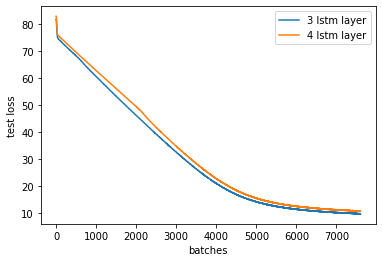

In [152]:
plot_differences(test_losses, test_losses2, ['3 lstm layer', '4 lstm layer'], 'batches', 'test loss')

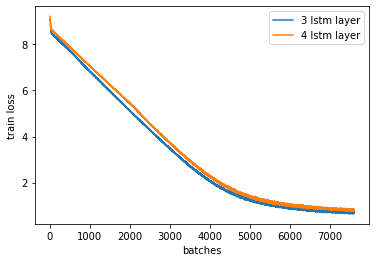

In [153]:
plot_differences(losses, losses2, ['3 lstm layer', '4 lstm layer'], 'batches', 'train loss')

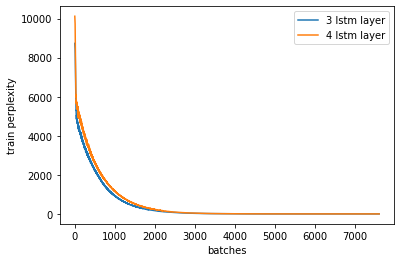

In [154]:
pp = np.exp(losses)
pp2 = np.exp(losses2)
plot_differences(pp, pp2, ['3 lstm layer', '4 lstm layer'], 'batches', 'train perplexity')

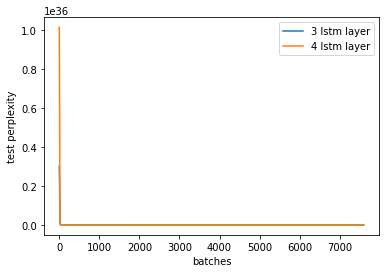

In [155]:
pp = np.exp(test_losses)
pp2 = np.exp(test_losses2)
plot_differences(pp, pp2, ['3 lstm layer', '4 lstm layer'], 'batches', 'test perplexity')

In [198]:
generated = text_generation(lstm2, '<s> she could get rid of her car if', size=20)
print(' '.join(generated))

<s> she could get rid of her car if curled water dual worn callous handling handling disappointed opinions eager sensations salivating curled water water dragon worn cup hides handling


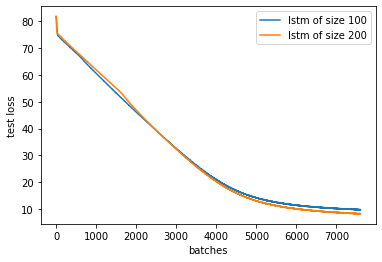

In [168]:
plot_differences(test_losses, test_losses3, ['lstm of size 100', 'lstm of size 200'], 'batches', 'test loss')

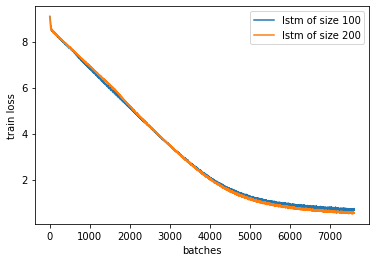

In [169]:
plot_differences(losses, losses3, ['lstm of size 100', 'lstm of size 200'], 'batches', 'train loss')

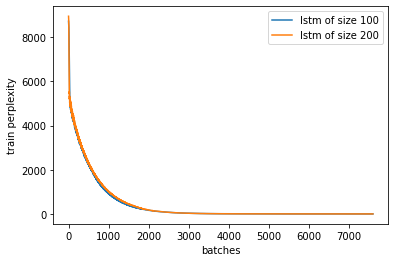

In [171]:
pp = np.exp(losses)
pp2 = np.exp(losses3)
plot_differences(pp, pp2, ['lstm of size 100', 'lstm of size 200'], 'batches', 'train perplexity')

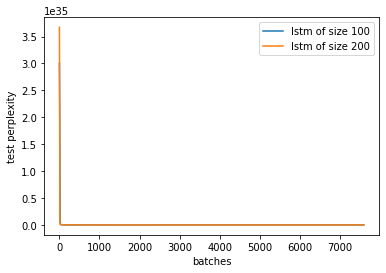

In [199]:
pp = np.exp(test_losses)
pp2 = np.exp(test_losses3)
plot_differences(pp, pp2, ['lstm of size 100', 'lstm of size 200'], 'batches', 'test perplexity')

In [200]:
generated = text_generation(lstm3, '<s> she could get rid of her car if', size=20)
print(' '.join(generated))

<s> she could get rid of her car if she could not remember the property of her life and her own life as she had gone . </s> he


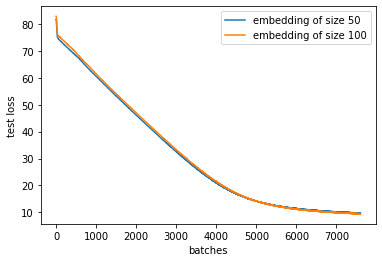

In [157]:
plot_differences(test_losses, test_losses4, ['embedding of size 50', 'embedding of size 100'], 'batches', 'test loss')

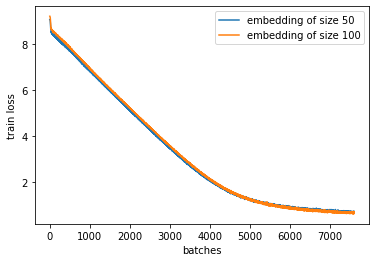

In [158]:
plot_differences(losses, losses4, ['embedding of size 50', 'embedding of size 100'], 'batches', 'train loss')

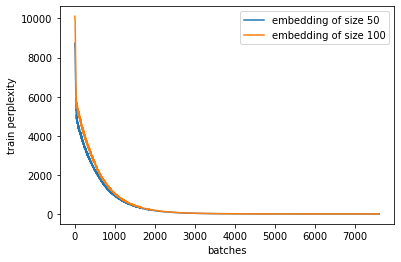

In [159]:
pp = np.exp(losses)
pp2 = np.exp(losses4)
plot_differences(pp, pp2, ['embedding of size 50', 'embedding of size 100'], 'batches', 'train perplexity')

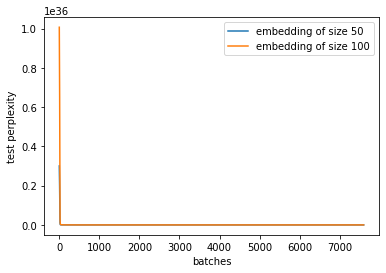

In [160]:
pp = np.exp(test_losses)
pp2 = np.exp(test_losses4)
plot_differences(pp, pp2, ['embedding of size 50', 'embedding of size 100'], 'batches', 'test perplexity')

In [201]:
generated = text_generation(lstm4, '<s> she could get rid of her car if', size=20)
print(' '.join(generated))

<s> she could get rid of her car if grab prick sensations plaster save angel worn water grab trunks save trunks water water water water water water water water


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


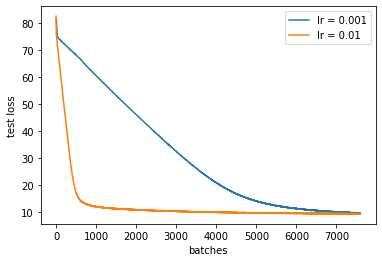

In [162]:
plot_differences(test_losses, test_losses5, ['lr = 0.001', 'lr = 0.01'], 'batches', 'test loss')

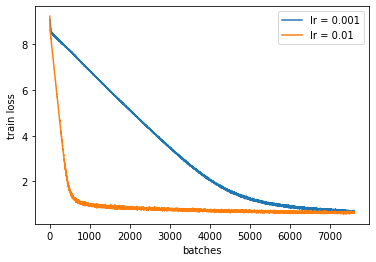

In [163]:
plot_differences(losses, losses5, ['lr = 0.001', 'lr = 0.01'], 'batches', 'train loss')

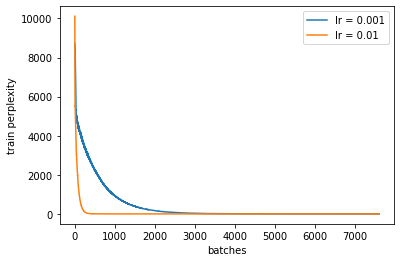

In [164]:
pp = np.exp(losses)
pp2 = np.exp(losses5)
plot_differences(pp, pp2, ['lr = 0.001', 'lr = 0.01'], 'batches', 'train perplexity')

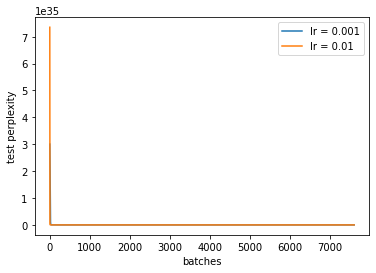

In [165]:
pp = np.exp(test_losses)
pp2 = np.exp(test_losses5)
plot_differences(pp, pp2, ['lr = 0.001', 'lr = 0.01'], 'batches', 'test perplexity')

In [203]:
generated = text_generation(lstm5, '<s> she could get rid of her car if', size=20)
print(' '.join(generated))

<s> she could get rid of her car if curled water curled water worn mouths contribution exceeded defied curled water grows grows wavelets grows exceeded wallet callous operator curled
